In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
_root = "/home/zjc1002/Mounts/code/admin/"


sys.path.append(_root)
from api_keys import _api_keys

hf_token = _api_keys["HUGGY_FACE_TOKEN"]


!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: fineGrained).
The token `zjc_colab` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticat

In [3]:
!pip install bertopic
!pip install sentence_transformers
!pip install transformers
!pip install torch
!pip install plotly
!pip install pandas
!pip install hdbscan
!pip install datamapplot
!pip install accelerate transformers bitsandbytes
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 4.5 MB/s eta 0:00:00
  Created wheel for Pyqtree: filename=Pyqtree-1.0.0-py3-none-any.whl size=5967 sha256=9710c3874d94fca72a05fef37c26204d8811bf68ab42c08a15e53c4d3c643aed
  Stored in directory: /root/.cache/pip/wheels/63/e6/90/6e15bfb4299fd41f88a9affca879f44bde40d3dc6f398462a8
Successfully built Pyqtree
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48

In [4]:
import sys, os, gc, pickle, torch, bertopic, requests
from pathlib import Path
import pandas as pd
from io import StringIO
import numpy as np
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, TextGeneration
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

def plot_complaints(df, date_var: str, plot_var: str
):
    # Calculate the volume of complaints by product and date
    complaints_by_product_and_date = df.groupby([date_var, plot_var]).size().unstack().fillna(0)

    # Calculate the percentage of total complaints for each product by date_var
    percentage_total = complaints_by_product_and_date.div(complaints_by_product_and_date.sum(axis=1), axis=0)
    ax = percentage_total.plot(kind='area', figsize=(20, 10))
    ax.title.set_text(f'Percentage of total complaints by {plot_var} and date')
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

    # Identifying Sub-Products with the highest increase in complaints and greatest %change in complaints
    percent_change_in_totals = percentage_total.pct_change()
    percent_change_in_totals.replace([float('inf'), -float('inf')], 0, inplace=True)

    # Identify top 20 Sub-products with the highest increase in complaints
    top20 = percent_change_in_totals.iloc[1:-1, :].max().sort_values(ascending=False).index[:20]
    ax = percent_change_in_totals[top20].plot(kind='line', figsize=(20, 5))
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    ax.title.set_text(f'Top 20 {plot_var} with the highest increase in %change in complaints in latest 3 weeks')

    ax = percentage_total[top20].plot(kind='area', stacked=True, figsize=(20, 5))
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    ax.title.set_text(f'Top 20 {plot_var} %total complaints in latest 3 weeks')

gc.collect()

256

In [5]:
torch.cuda.empty_cache()
gc.collect()

0

### Source Latest Data From CFPB API

In [6]:
#pull down latest complaints
url = 'https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/?field=complaint_what_happened&date_received_min=2024-10-15'
headers = {'accept': 'text/csv'}
wf_only = True
_trim = True
samp_ = None

#input / descriptive columns to model
text_col = 'Consumer complaint narrative'
title_cols = ['Product', 'Sub-product', 'Issue', 'Sub-issue']


#read data
response = requests.get(url, headers=headers)
data = StringIO(response.text)
_df = pd.read_csv(data)

# Convert 'Date received' to datetime
_df['Week of Year'] = pd.to_datetime(_df['Date received']).dt.isocalendar().week

#filter out null strings
df = _df[_df['Consumer complaint narrative'].notnull()]
df = df.drop_duplicates(subset=['Consumer complaint narrative'])
df = df.sort_values(by='Date received',ascending=False)

#if you only want topics for wells set to True
if wf_only:
  df = df[df['Company']=='WELLS FARGO & COMPANY']
  print(df.Company.value_counts().head(10))
  print(df['Date received'].max())

#subset and trim if asked
if _trim:
    df['_Consumer complaint narrative']= df['Consumer complaint narrative'].apply(lambda x: f"{x[:2000]} {x[-2000:]}")
else:
    df['_Consumer complaint narrative']= df['Consumer complaint narrative']

#samp if requested
if samp_ is not None:
  #delete parent df
  del(_df)
  df = df.sample(samp_)

df = df.reset_index(drop=True)

Company
WELLS FARGO & COMPANY    628
Name: count, dtype: int64
12/02/24


### 1. Summarize Complaints and generate features with llama3

In [84]:
import torch
import transformers
from datasets import Dataset
class Llama3:
    def __init__(self, model_path):
        self.model_id = model_path
        self.pipeline = transformers.pipeline(
            "text-generation",
            model=self.model_id,
            model_kwargs={
                "torch_dtype": torch.float16,
                "quantization_config": {"load_in_4bit": True},
                "low_cpu_mem_usage": True,
            },
        )
        self.terminators = [
            self.pipeline.tokenizer.eos_token_id,
            #self.pipeline.tokenizer.convert_tokens_to_ids(""),
        ]

    def get_response(
          self, query, message_history=[], max_tokens=4096, temperature=0.6, top_p=0.9, batch_size=10
      ):
        user_prompt = message_history + [{"role": "user", "content": query}]
        prompt = self.pipeline.tokenizer.apply_chat_template(
            user_prompt, tokenize=False, add_generation_prompt=True
        )
        outputs = self.pipeline(
            prompt,
            max_new_tokens=max_tokens,
            eos_token_id=self.terminators,
            do_sample=True,
            temperature=temperature,
            top_p=top_p, batch_size=batch_size
        )
        response = outputs[0]["generated_text"][len(prompt):]
        return response, user_prompt + [{"role": "assistant", "content": response}]

    def chatbot(self, system_instructions=""):
        conversation = [{"role": "system", "content": system_instructions}]
        while True:
            user_input = input("User: ")
            if user_input.lower() in ["exit", "quit"]:
                print("Exiting the chatbot. Goodbye!")
                break
            response, conversation = self.get_response(user_input, conversation)
            print(f"Assistant: {response}")

def clean_llama3_response(r):
  """fix formatting errors in llama3 dictionary response"""
  try:
    #json.loads(r[0].replace("'", '"'))
    return ast.literal_eval(re.sub(' +',' ',r.strip()))

  except:
    try:
      return ast.literal_eval(re.sub(' +',' ',r.strip()
             ).replace('"s','s'))

    except:
      try:
        return ast.literal_eval(
              re.sub(' +',' ',r.strip()
              ).replace('"s','s'
              ).replace('"t','t'
              ).replace('\s','s'
              ).replace('s"','s'))
      except:
        try:

          return ast.literal_eval(
                re.sub(r'(?<!")\b,\b(?!")', '', r.replace('""s','s').replace('"s','s')))

        except:
          print('error')
          raise Exception("Failed")


def l3_summarize(user_instructions, text):

  _summary_prompt = f"""
  <|begin_of_text|><|start_header_id|>system<|end_header_id|>{user_instructions}
  <|eot_id|><|start_header_id|>transcript<|end_header_id|>{text}<|eot_id|><|start_header_id|>user<|end_header_id|>

  Important reminders:
    - Keep your summary under 300 words.
    - Provide only the requested information in the specified </output> format.
    - Do not include any additional explanations or comments outside of the summary and numerical rankings.
    - Ensure that your output is a valid Python dictionary.
    - Each result must be a single dictionary containing the following keys: ['Topic','R1','R2','R3','R4','R5]

    <|eot_id|>
  """

  return _summary_prompt

NameError: name '_model_id_l3' is not defined

In [ ]:
#create the dataset
a = Dataset.from_pandas(df)

#set up the bot
model_id_l3 = "meta-llama/Llama-3.2-3B-Instruct"
bot = Llama3(_model_id_l3)


#bot instructions
user_instructions = """You are an AI assistant tasked with summarizing and analyzing information related to banking and financial services. Your goal is to summarize the main topic of the provided document and rank its relevance to various categories.

    Your tasks are as follows:

    1. Summarize the main topic:
    - Carefully read through all the provided information.
    - Identify key points related to the product, issue, customer complaint, and company response.
    - Create a clear and concise summary of less than 300 words.
    - Do not use punctuation in the summaries
    - Focus on the most important aspects of the situation, especially any information related to the categories mentioned in task 2.

    2. Score the relevance of the information to the following categories on a scale from 1 to 10 (where 1 is least relevant and 10 is most relevant):
    [R1] Illegal activity
    [R2] Large cash transactions
    [R3] Bank employee actions being dishonest
    [R4] Actions that put customers physical safety at risk
    [R5] Employee schemes and misconduct
    [R6] Branch Banking Operations

    For each category:
    - Consider how closely the information relates to the category.
    - Assign a score from 1 to 10 based on its relevance.
    - Do not provide explanations or justifications for your rankings.


    Present your answer as a python dictionary with the below format:

    <output>
    "{'Topic': [r'summary'], 'R1': [score], 'R2': [score], 'R3': [score] , 'R4':[score], 'R5':[score], 'R6':[score]}"
    </output>
"""

#execute summarization
responses  = [bot.get_response(l3_summarize(user_instructions, x))
    for x in a['_Consumer complaint narrative']]

#extract and clean summary
summary_info = [x[0] for x in responses]
fin = [clean_llama3_response(x) for x in summary_info]
assert len(fin) == len(df),  'you lost repsonses and indexs are not equal'

# Save the list to a pickle file
with open('/content/drive/MyDrive/colab_files/llama3_cfpb_wf_summaries.pkl', 'wb') as f:
    pickle.dump(fin, f)


In [105]:
#load resuilts
l3_results_df = pd.DataFrame(fin)
l3_results_df.columns = ['llama3_short_summary','illegal_activity_risk','large_cash_transaction_risk','employee_dishonest_risk','customer_saftey_risk','employee_scheme_risk']


#merge  with original cfpb
bert_topic_input = pd.merge(df[['Date received','Week of year','Complaint ID','Product','Sub-product'
                                ,'Issue','Sub-issue','Consumer complaint narrative'
                                ,'Company public response','ZIP code']]
                            , l3_results_df
                            ,  how ='left'
                            , left_index =True,right_index=True)

bert_topic_input.head(2).T

,0,1
Date received,12/02/24,12/02/24
Complaint ID,10991824,10989616
Product,Credit reporting or other personal consumer re...,Checking or savings account
Sub-product,Credit reporting,Checking account
Issue,Problem with a company's investigation into an...,Problem caused by your funds being low
Sub-issue,Problem with personal statement of dispute,Overdrafts and overdraft fees
Consumer complaint narrative,Dispute late charges on the mortgage payments ...,I went in and talk to the banker about the ove...
Company public response,Company has responded to the consumer and the ...,Company has responded to the consumer and the ...
ZIP code,604XX,52404
llama3_short_summary,Wells Fargo disputes late charges on mortgage ...,I went in and talk to the banker about the ove...


In [108]:
####LLAMA 2 Template
# System prompt describes information given to all conversations
system_prompt = """
<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant for labeling topics.
<</SYS>>
"""

# Example prompt demonstrating the output we are looking for
example_prompt = """
I have a topic that contains the following documents:
- On XX/XX/year> I had opened a checking account with BMO Bank. I had made a deposit of {$15000.00} the day I had opened the account. After my initial deposit cleared 5-7 days later I was informed that I needed to come down to the bank because they were closing the account due to my credit score being low at which time I was issued a cashiers check from BMO Bank in the amount of {$15000.00} ( the balance of my account. I then took the cashier 's check to BMO Bank ( since they were the bank who issued the check ) and the bank teller informed me that they did not have enough funds to cash it and that I would need to take it to another bank because they do not have enough money to cover it.. This is a serious violation and I will be getting legal assistance regarding this matter. I feel I was discriminated against because of the color of my skin.
- On my first visit to the Wells Fargo XXXX location XX/XX/XXXX, I attempted to withdraw {$11000.00} from my account. I arrived around XXXX PM, provided all necessary information, and was told the funds were available in my account. A teller appeared unsure and called someone over to verify the transaction. I was asked to sit and wait. By the time XXXX XXXX approached, the bank closed, and I was still waiting. During this time, a police officer asked what I was trying to do. I explained I was simply withdrawing funds already reflected in my account. Ultimately, I was told my funds would take XXXX business days to clear, despite the balance already being visible. \n\nThe bank suggested I withdraw {$2000.00} daily from the ATM instead, but I declined for safety reasons, as the area is not secure, and withdrawing in increments seemed unnecessary. I left feeling frustrated but decided to return the following week, as I had another check to deposit. \n\nOn my second visit XX/XX/XXXX, I arrived earlier to avoid delays. I deposited {$25000.00} check and again requested to withdraw {$9000.00}. Despite the funds being available, I was subjected to another round of verifications. A teller recognized me from the previous visit, but a XXXX, XXXX XXXX, intervened. XXXX was dismissive, insisted on unnecessary steps, and loudly told me to leave the bank. When I asked for a valid reason why I could not access my funds, she refused to provide XXXX, claiming again that the withdrawal required XXXX business days for approval. \n\nI was humiliated as XXXX yelled at me in front of other customers and instructed the police to escort me out. I was not hostile, disrespectful, or disruptive. I simply stood firm on wanting access to my funds. \n\nTo confirm this was not standard procedure, I went to another Wells Fargo location at XXXX XXXX, where I successfully obtained a {$21000.00} cashiers check without issue. This clearly demonstrates that my funds were available all along. Tracys actions were unnecessary, discriminatory, and unprofessional. \n\nI have been a loyal Wells Fargo customer for years and have never experienced such mistreatment. Her behavior was not only humiliating but also raises questions about fair treatment at this location. I am seeking answers and accountability for this experience. \n\nBanking Regulations These laws regulate how banks operate and ensure fairness, transparency, and accountability.
- On XX/XX/year> I had opened a checking account with BMO Bank. I had made a deposit of {$15000.00} the day I had opened the account. After my initial deposit cleared 5-7 days later I was informed that I needed to come down to the bank because they were closing the account due to my credit score being low at which time I was issued a cashiers check from BMO Bank in the amount of {$15000.00} ( the balance of my account. I then took the cashier 's check to BMO Bank ( since they were the bank who issued the check ) and the bank teller informed me that they did not have enough funds to cash it and that I would need to take it to another bank because they do not have enough money to cover it.. This is a serious violation and I will be getting legal assistance regarding this matter. I feel I was discriminated against because of the color of my skin.

The topic is described by the following keywords: 'deposit, cash, withdraw, saving, checking'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.
[/INST] High Fraud Risk cash deposits and withdrawals
"""

# Our main prompt with documents ([DOCUMENTS]) and keywords ([KEYWORDS]) tags from BERTOPIC
main_prompt = """
[INST]
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.
[/INST]
"""

#final prompt
prompt = system_prompt + example_prompt + main_prompt

In [110]:
del bot
torch.cuda.empty_cache()
gc.collect()

10590

In [111]:
#LOAD FROM LOCAL
#tok = transformers.AutoTokenizer.from_pretrained("/home/zjc1002/Mounts/llms/TheBloke_Llama-2-7B-Chat-GGUF")
#model_id = "TheBloke/TinyLlama-1.1B-Chat-v0.3-GGUF"
#filename = "tinyllama-1.1b-chat-v0.3.Q5_K_S.gguf"
#llm = AutoModelForCausalLM.from_pretrained(model_id, model_file=filename, model_type="llama", gpu_layers=2)
#tokenizer = AutoTokenizer.from_pretrained(model_id)

#LOAD FROM HF
model__id = "TinyLlama/TinyLlama-1.1B-Chat-v0.6"
model__id = "QuantFactory/llama2_7b_chat_uncensored-GGUF"
model__id = 'meta-llama/Llama-2-7b-chat-hf'
model__id = 'meta-llama/Llama-2-13b-chat-hf'
#model__id = "meta-llama/Llama-3.2-3B-Instruct"

#DOWNLOAD LIVE FROM HUGGINGFACE WORKS
model = AutoModelForCausalLM.from_pretrained(model__id, trust_remote_code=True, device_map="auto", torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model__id)

#align padding and eos tokens
model.generation_config.pad_token_id = model.generation_config.eos_token_id

#clear unused gpu cache
torch.cuda.empty_cache()
gc.collect()

config.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/33.4k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/9.90G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/6.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

48

In [112]:
#establish generator pipeline for keybert
generator = pipeline(
                 model=model
                , tokenizer = tokenizer
                , task = 'text-generation'
                , torch_dtype=torch.bfloat16
                , device_map="auto"
                , temperature = 0.2
                , max_new_tokens=1000
                , repetition_penalty=1.5
#                , batch_size = 50
                , truncation = False
                )

tokenizer = AutoTokenizer.from_pretrained(model__id)

In [124]:
#### Precalculate embeddings for use in topic modeling (snipping the start and end of each complaint to be conservative with seq length)
#abstracts = [x[:800]+x[-900:] for x in df['Consumer complaint narrative'].tolist()]
abstracts = [x.replace('Wells Fargo','') for x in bert_topic_input['llama3_short_summary'].tolist()]
titles = bert_topic_input.fillna('').apply(lambda x: x['Product'] +x['Sub-product']+x['Issue']+x['Sub-issue'],axis=1).tolist()

# Load the pre-trained Sentence Transformer model
_encoder_model_id = 'BAAI/bge-large-en-v1.5'
embedding_model = SentenceTransformer(_encoder_model_id,device='cuda')

# Encode the abstracts
embeddings = embedding_model.encode(abstracts, show_progress_bar=True)

#clear it
torch.cuda.empty_cache()
gc.collect()

Batches:   0%|          | 0/20 [00:00<?, ?it/s]

48

In [136]:
# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors= 3#int(round(len(df)/(len(df)/40),0))
                          , n_components=2
                          , min_dist=0.0
                          , metric='cosine'
                          , random_state=42
                          ).fit_transform(embeddings)

In [135]:
#define sub-models for BERTopic
umap_model = UMAP(n_neighbors= 3 #int(round(len(df)/(len(df)/40),0))
                  , n_components=4
                  , min_dist=0.0
                  , metric='cosine'
                  , random_state=42)

hdbscan_model = HDBSCAN(min_cluster_size= 6 #int(round(len(df)/(len(df)/38),0))
                        , metric='euclidean'
                        , cluster_selection_method='eom'
                        , prediction_data=True)

In [131]:
from bertopic.representation import TextGeneration

class CustomTextGeneration(TextGeneration):
    def __init__(self, generator, prompt, nr_docs=2):  # Add nr_docs parameter
        super().__init__(generator, prompt)
        self.nr_docs = nr_docs

    def __call__(self, topic_model, topic):
        # ... (Existing code) ...

        # Select the top `nr_docs` documents
        documents = topic_model.get_representative_docs(topic)[:self.nr_docs]


In [137]:
# Define Representation Models for BERTopic and KeyBERT
# KeyBERT
keybert = KeyBERTInspired(  )

# MMR
mmr = MaximalMarginalRelevance(diversity=0.6)

# Text generation with Llama 2(prompt) or llama3 (l3_prompt)
llama2 = TextGeneration(generator
                        , prompt= prompt ) #prompt

# All representation models
representation_model = {
    "KeyBERT": keybert,
    "Llama2": llama2,
    "MMR": mmr,
}

#clear it
torch.cuda.empty_cache()
gc.collect()

10

In [138]:
#INITALIZE TOPIC MODEL PIPELINE
topic_model = BERTopic(
  #ngram range
  #ngram_range(1,2)
  # Embedding model
   embedding_model=embedding_model,

  # dimension reduction / feature extraction models
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,

  #generation model
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=6,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(abstracts, embeddings )


# Save model
# Method 3 - pickle
#topic_model.save("my_model_bertllama_v1", serialization="pickle")

2024-12-12 15:01:59,139 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-12 15:02:00,330 - BERTopic - Dimensionality - Completed ✓
2024-12-12 15:02:00,331 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-12 15:02:00,359 - BERTopic - Cluster - Completed ✓
2024-12-12 15:02:00,362 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 32/32 [00:22<00:00,  1.41it/s]
2024-12-12 15:02:26,730 - BERTopic - Representation - Completed ✓


In [142]:
#update labels from topic model to use Custom Llama2 generated labels
llama2_labels = [label[0][0].split("\n")[0].replace('"','').replace('"','').replace(":","") for label in topic_model.get_topics(full=True)["Llama2"].values()]
topic_model.set_topic_labels(llama2_labels)
llama2_labels

['Checking Account Issues & Payment Disputes',
 'Customer Disputes & Unauthorized Charges',
 'Mortgage Loan Issues',
 'Overdrawn Grace Period Abuse',
 'Customer Account Closures & Disputes',
 'Unauthorized Transactions & Mishandling Dispute',
 'Fraud Disputes & Scams',
 'Check Deposit Disputes & Delayed Direct Deposits',
 "Un ethical Bank Practices & Employees' Behavior ",
 'Checking & Savings Account Hacking Scandals',
 'Debit Card Unauthorized Charges Dispute',
 'Financial Scams & Losses',
 'Check Issues & Remediation Complaints',
 'Check Deposit Disputes & Issues',
 'Fraudulent Wire Transactions & Scams',
 'Checking Account Bonus Disputes',
 'Debit Card Disputes & Unauthorized Transactions',
 'ATM disputes & poor cust serv',
 'Wire Transfer Issues & Disputes',
 'Credit Report Violations',
 'Credit Report Disputes & Bank Misconduct',
 'Credit Disputes & Negative Impact',
 'Credit Report Disputes & Discrimination',
 'Scams & Financial Crimes',
 'Credit Report Dispute Resolution',
 'Id

In [146]:
### Assign topics back to data and save to file for sending to marc
bert_topic_input['topic'] = topics
bert_topic_input['topic_label'] = bert_topic_input['topic'].map(topic_model.get_topic_info()['CustomName'])
bert_topic_input.to_excel('/content/drive/MyDrive/colab_files/bert_topic_enriched_output.xlsx')
#df.to_excel('wf_df_topics.xlsx')
bert_topic_input.head(3).T

,0,1,2
Date received,12/02/24,12/02/24,12/01/24
Complaint ID,10991824,10989616,10988520
Product,Credit reporting or other personal consumer re...,Checking or savings account,Checking or savings account
Sub-product,Credit reporting,Checking account,Savings account
Issue,Problem with a company's investigation into an...,Problem caused by your funds being low,Problem caused by your funds being low
Sub-issue,Problem with personal statement of dispute,Overdrafts and overdraft fees,Non-sufficient funds and associated fees
Consumer complaint narrative,Dispute late charges on the mortgage payments ...,I went in and talk to the banker about the ove...,XXXX I was offered a settlement with Wells Fa...
Company public response,Company has responded to the consumer and the ...,Company has responded to the consumer and the ...,Company has responded to the consumer and the ...
ZIP code,604XX,52404,19131
llama3_short_summary,Wells Fargo disputes late charges on mortgage ...,I went in and talk to the banker about the ove...,Wells Fargo customer dispute and settlement


In [144]:
#view the topics
pd.set_option('display.max_rows', None)
topic_model.get_topic_info().head(3).T

,0,1,2
Topic,-1,0,1
Count,71,86,58
Name,-1_their_the_customer_is,0_customer_unauthorized_and_complaint,1_mortgage_loan_process_home
CustomName,Checking Account Issues & Payment Disputes,Customer Disputes & Unauthorized Charges,Mortgage Loan Issues
Representation,"[their, the, customer, is, to, and]","[customer, unauthorized, and, complaint, charg...","[mortgage, loan, process, home, modification, ..."
KeyBERT,"[fraudulent, fraud, customer, dispute, disputi...","[disputes, dispute, complaint, disputing, comp...","[complaint, lender, complaints, mortgage, loan..."
Llama2,"[Checking Account Issues & Payment Disputes, ,...","[Customer Disputes & Unauthorized Charges, , ,...","[""Mortgage Loan Issues"":, , , , , , , , , ]"
MMR,"[account, check, complaint, transactions, cred...","[unauthorized, complaint, charges, dispute, to...","[loan, process, modification, foreclosure, app..."
Representative_Docs,[A customer experienced a scam involving a che...,[A customer is disputing a charge of $170.00 f...,[ and the customer dispute over a mortgage loa...


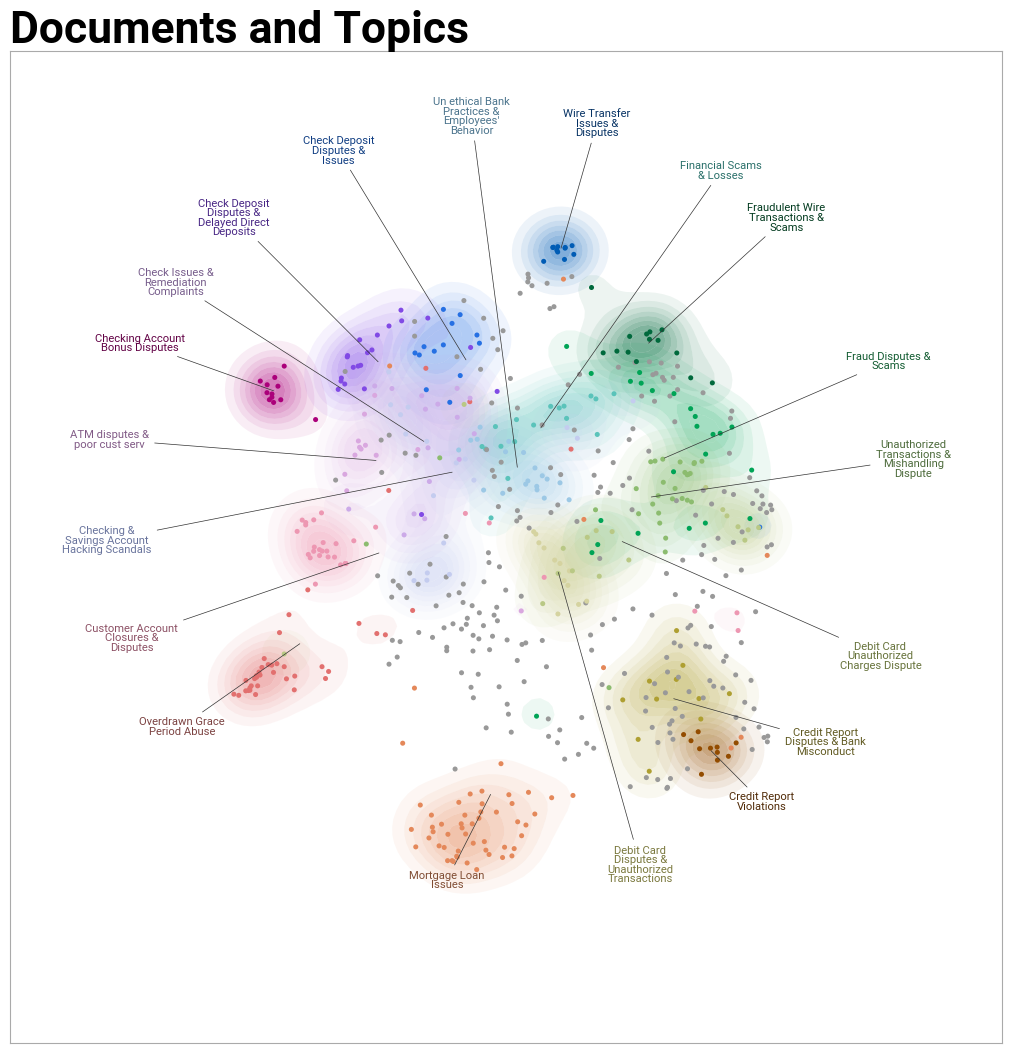

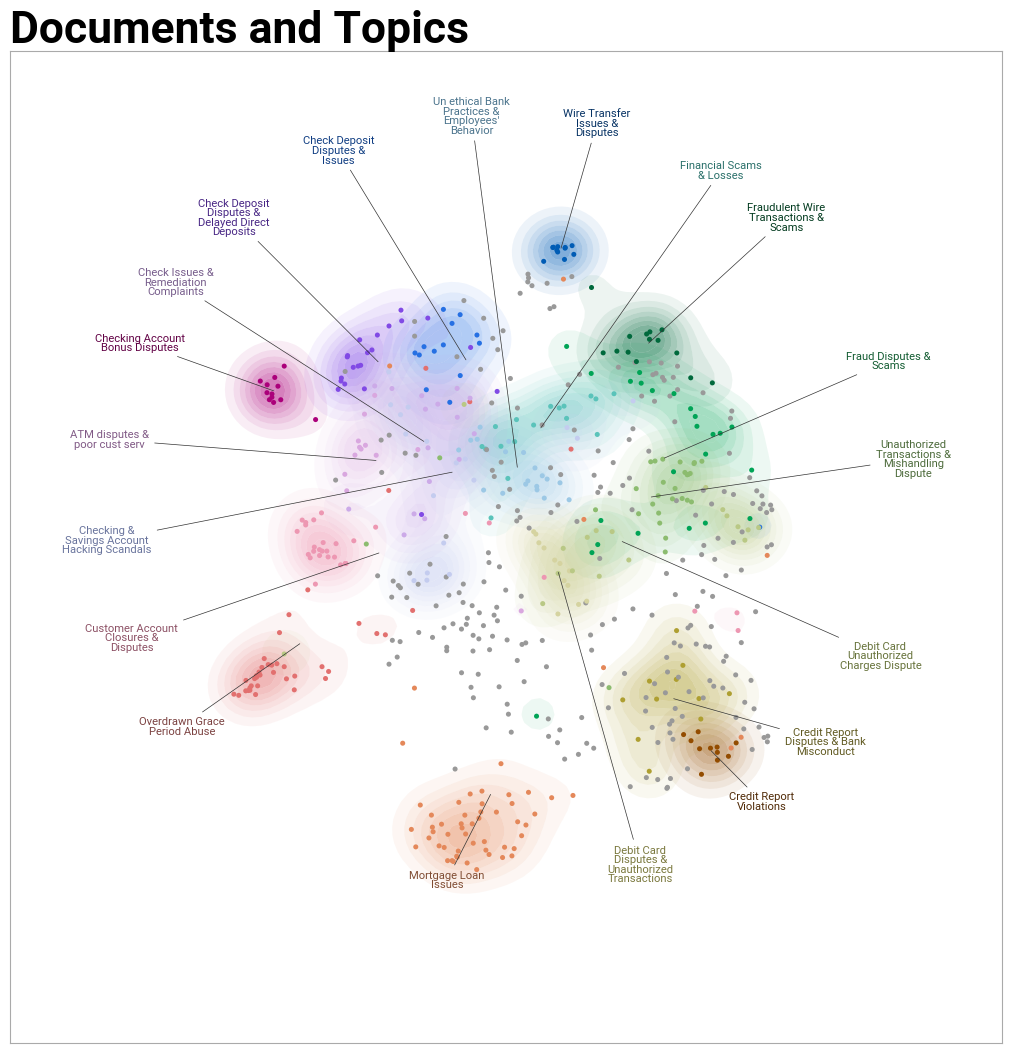

In [145]:
# with the original embeddings
topic_model.visualize_document_datamap(abstracts, embeddings=embeddings,custom_labels=True,height=1000, width=1000)


### Trending Topics
- Transfer Disputes
- Fraud Claims

In [152]:
timestamps =[x for x in bert_topic_input['Date received'].tolist()]
topics_over_time = topic_model.topics_over_time(abstracts, timestamps)
topic_model.visualize_topics_over_time(topics_over_time,custom_labels=True)

49it [00:00, 81.66it/s]


In [153]:
topic_model.visualize_documents(titles, reduced_embeddings=reduced_embeddings,
hide_annotations=True, hide_document_hover= False
                                 , custom_labels=True
                                 , topics = [i for i in range(1,35)])

In [ ]:
# Calculate the topic distributions on a token-level
topic_distr, topic_token_distr = topic_model.approximate_distribution(abstracts, calculate_tokens=True)


# Visualize the token-level distributions
dd = topic_model.visualize_approximate_distribution(abstracts[1], topic_token_distr[1])


100%|██████████| 1/1 [00:03<00:00,  3.13s/it]


In [154]:
topic_model.visualize_topics()

In [157]:
topics_per_class = topic_model.topics_per_class(abstracts, classes=titles)
topic_model.visualize_topics_per_class(topics_per_class,top_n_topics=5)

190it [00:01, 163.96it/s]


In [158]:
topic_model.visualize_barchart()

In [159]:
topic_model.visualize_term_rank()
topic_model.visualize_term_rank(log_scale=True)

In [160]:
hierarchical_topics = topic_model.hierarchical_topics(abstracts)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics,custom_labels=True)

100%|██████████| 30/30 [00:00<00:00, 302.85it/s]


# END

In [ ]:
#LOOKUP BY ROW
# #cash  / deposit related complaints
# _id = 'Complaint ID'
# _idlookup_list = ['10820022','10916374']
# df[df[_id].str.isin(_idlookup_list)]


# # Save and load model
# topic_model.save("my_bert_model")
# my_model = BERTopic.load("my_model")
# new_topics, new_probs = my_model.transform(docs, embeddings)
# pickle.dump(topics, open( "topics.pickle", "wb" ) )
# assert topics == new_topics
#
#del llama2 , model

In [ ]:

#### LLama3 Tempalte
system_prompt = """
<|begin_of_text|>
<|start_header_id|>system<|end_header_id|>
You are a helpful, respectful and honest assistant for labeling topics. Specifically you are responsible to labeling topics associated with complaints specific to banking operations.
<|eot_id|>
"""

example_prompt = """
<|start_header_id|>user<|end_header_id|>
I have a topic that contains the following documents:
- On XX/XX/year> I had opened a checking account with BMO Bank. I had made a deposit of {$15000.00} the day I had opened the account. After my initial deposit cleared 5-7 days later I was informed that I needed to come down to the bank because they were closing the account due to my credit score being low at which time I was issued a cashiers check from BMO Bank in the amount of {$15000.00} ( the balance of my account. I then took the cashier 's check to BMO Bank ( since they were the bank who issued the check ) and the bank teller informed me that they did not have enough funds to cash it and that I would need to take it to another bank because they do not have enough money to cover it.. This is a serious violation and I will be getting legal assistance regarding this matter. I feel I was discriminated against because of the color of my skin.
- On my first visit to the Wells Fargo XXXX location XX/XX/XXXX, I attempted to withdraw {$11000.00} from my account. I arrived around XXXX PM, provided all necessary information, and was told the funds were available in my account. A teller appeared unsure and called someone over to verify the transaction. I was asked to sit and wait. By the time XXXX XXXX approached, the bank closed, and I was still waiting. During this time, a police officer asked what I was trying to do. I explained I was simply withdrawing funds already reflected in my account. Ultimately, I was told my funds would take XXXX business days to clear, despite the balance already being visible. \n\nThe bank suggested I withdraw {$2000.00} daily from the ATM instead, but I declined for safety reasons, as the area is not secure, and withdrawing in increments seemed unnecessary. I left feeling frustrated but decided to return the following week, as I had another check to deposit. \n\nOn my second visit XX/XX/XXXX, I arrived earlier to avoid delays. I deposited {$25000.00} check and again requested to withdraw {$9000.00}. Despite the funds being available, I was subjected to another round of verifications. A teller recognized me from the previous visit, but a XXXX, XXXX XXXX, intervened. XXXX was dismissive, insisted on unnecessary steps, and loudly told me to leave the bank. When I asked for a valid reason why I could not access my funds, she refused to provide XXXX, claiming again that the withdrawal required XXXX business days for approval. \n\nI was humiliated as XXXX yelled at me in front of other customers and instructed the police to escort me out. I was not hostile, disrespectful, or disruptive. I simply stood firm on wanting access to my funds. \n\nTo confirm this was not standard procedure, I went to another Wells Fargo location at XXXX XXXX, where I successfully obtained a {$21000.00} cashiers check without issue. This clearly demonstrates that my funds were available all along. Tracys actions were unnecessary, discriminatory, and unprofessional. \n\nI have been a loyal Wells Fargo customer for years and have never experienced such mistreatment. Her behavior was not only humiliating but also raises questions about fair treatment at this location. I am seeking answers and accountability for this experience. \n\nBanking Regulations These laws regulate how banks operate and ensure fairness, transparency, and accountability.
- On XX/XX/year> I had opened a checking account with BMO Bank. I had made a deposit of {$15000.00} the day I had opened the account. After my initial deposit cleared 5-7 days later I was informed that I needed to come down to the bank because they were closing the account due to my credit score being low at which time I was issued a cashiers check from BMO Bank in the amount of {$15000.00} ( the balance of my account. I then took the cashier 's check to BMO Bank ( since they were the bank who issued the check ) and the bank teller informed me that they did not have enough funds to cash it and that I would need to take it to another bank because they do not have enough money to cover it.. This is a serious violation and I will be getting legal assistance regarding this matter. I feel I was discriminated against because of the color of my skin.

The topic is described by the following keywords: 'deposit, cash, withdraw, saving, checking'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.
<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>
High Fraud Risk cash deposits and withdrawals
<|eot_id|>
"""

main_prompt = """
<|start_header_id|>user<|end_header_id|>
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the information about the topic above, please create a short label of this topic. Make sure you to only return the label and nothing more.
<|eot_id|>
"""

#final prompt
l3_prompt= system_prompt + example_prompt + main_prompt

In [ ]:
# INTERESTING COMPLAINTS
# complaint_dict = [
#     {'complaint_type':'large_dollar_transactions_inbranch'
#      ,'complaint_ids': ['10916374','10725157','10726802','10794454','10909443']
#      }
#      , {'complaint_type': 'Internal Bank Collusion Indicators'
#         , 'complaint_ids': ['10879337']
#      }

#      , {'complaint_type': 'Crypto / Wire Sceme'
#         , 'complaint_ids': ['10768001', '10875274']
#      }
#      , {'complaint_type':'Wells Fargo'
#         , 'complaint_ids': ['10762551']
#         }
# ]

#flag high dollar complaints found by claude in independent processes
#df['cash_intensive'] = df['Complaint ID'].apply(lambda x: True if str(x) in ['10916374','10725157','10726802','10794454','10909443'] else False)
#df['cash_intensive'].value_counts()